In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [2]:
class HomeDataInitializer:
    def __init__(self,
                 device_info=r'E:\OfficialWorkRemote\OfficialWork\SIOA\WorkflowOptimize\SourceData\DeviceInfo.csv',
                 external_info=r'E:\OfficialWorkRemote\OfficialWork\SIOA\WorkflowOptimize\SourceData\ExternalInfo.csv'):
        self.device_pd = pd.read_csv(device_info)
        self.external_pd = pd.read_csv(external_info)


class SimuAnneal:
    def __init__(self, device_pd, external_dic, max_temperature=100, min_temperature=25,
                 cooling_alpha=0.95, iter_round=1000, search_step=2, inner_loop_round=100, day_index=0):
        self.device_pd = device_pd
        # device相关信息
        self.device_u = self.device_pd['UserPresence']
        self.device_e = self.device_pd['EnergyCost']
        self.device_t = self.device_pd['Tidiness']
        # external相关信息
        self.external_u = external_dic['UserPresence']
        self.external_epr = external_dic['EnergyCost']
        self.external_thr = external_dic['Threshold']

        # 退火算法相关参数
        self.temperature_pos = max_temperature  # 当前温度
        self.max_temperature = max_temperature  # 最大温度
        self.min_temperature = min_temperature  # 停止迭代时的最小温度
        self.cooling_alpha = cooling_alpha  # 降温系数
        self.iter_round = iter_round  # 最大迭代次数
        self.search_step = search_step  # 搜索步长
        self.iter_round_local = 0  # 当前迭代次数
        self.inner_loop_round = inner_loop_round

        # 计算适应度的三个系数
        self.omega_1 = 1
        self.omega_2 = 1
        self.omega_3 = 1
        # 初始解(invalid的device就是0)
        self.solution_pos = self.solution_init()
        self.best_solution = self.solution_pos
        self.best_solution_fitness_val = self.evaluate_fitness(self.best_solution)

        # 迭代记录
        self.best_solution_iter = [self.best_solution]
        self.best_solution_fitness_iter = [self.best_solution_fitness_val]
        self.day_index = day_index

    # 判断设备是否失效，输入device index
    def device_invalid(self, device_index):
        return self.device_u[device_index] == 1 and self.external_u == 0

    # 随机初始化解
    def solution_init(self):
        solution_pos = [0 for _ in range(self.device_pd.shape[0])]
        while True:
            if np.array(solution_pos).sum() != 0:
                break
            for pos_index in range(len(solution_pos)):
                if self.device_invalid(pos_index):
                    continue
                rand_num = np.random.randint(0, 2)
                solution_pos[pos_index] = rand_num
        return solution_pos

    # 输入solution_list，计算适应度值（需要保证输入的solution_list不全为0）
    def evaluate_fitness(self, solution_list):
        u_flow = 0
        e_flow = 0
        t_flow = 0
        device_num = 0
        for device_index in range(len(solution_list)):
            if solution_list[device_index] == 1:
                device_num += 1
                u_flow += self.device_u[device_index]
                e_flow += self.device_e[device_index]
                t_flow += self.device_t[device_index]
        u_flow = u_flow / device_num
        f1 = 1 - np.abs(self.external_u - u_flow)
        f3 = t_flow
        f2 = 0
        if self.external_epr * e_flow < self.external_thr:
            f2 = 1 - self.external_epr * e_flow / self.external_thr
        return (self.omega_1 * f1 + self.omega_2 * f2 + self.omega_3 * f3) / (
                    self.omega_1 + self.omega_2 + self.omega_3)

    # 在当前解周围随机产生新解,搜索步长就是随机挑选若干个位置的有效设备，如果是0则变成1，如果是1则变成0
    def generate_solution(self):
        new_solution = self.solution_pos.copy()
        step_recrd = self.search_step
        while True:
            if step_recrd <= 0 and np.array(new_solution).sum() != 0:
                break
            rd_point = np.random.randint(0, len(new_solution))
            if not self.device_invalid(rd_point):
                new_solution[rd_point] = 0 if new_solution[rd_point] == 1 else 1
                step_recrd -= 1
        return new_solution

    # 迭代停止控制
    def stop_control(self):
        return self.iter_round_local >= self.iter_round or self.temperature_pos <= self.min_temperature

    # 更新最优解
    def update_best_solution(self, new_solution, new_solution_func_val):
        if new_solution_func_val > self.best_solution_fitness_val:
            self.best_solution = copy.deepcopy(new_solution)
            self.best_solution_fitness_val = new_solution_func_val

    # 迭代记录
    def iter_record(self):
        self.best_solution_iter.append(self.best_solution)
        self.best_solution_fitness_iter.append(self.best_solution_fitness_val)
        pass

    # 当前温度水平下的内部循环调整寻优过程
    def inner_loop(self):
        for _ in range(self.inner_loop_round):
            if self.stop_control():
                break
            # 在当前解的基础上左右随机搜索产生新解
            new_solution = self.generate_solution()
            new_solution_fitness_val = self.evaluate_fitness(new_solution)
            # 计算旧解的适应度值
            local_solution_fitness_val = self.evaluate_fitness(self.solution_pos)
            dE = local_solution_fitness_val - new_solution_fitness_val
            if dE <= 0:
                # 新解更优，接受新解
                self.solution_pos = new_solution
                # 看是否能够更新最优解
                self.update_best_solution(new_solution, new_solution_fitness_val)
            else:
                # 新解比较差，一定给定概率接受新解
                rand_point = np.random.rand()
                if rand_point <= np.exp(-dE / self.temperature_pos):
                    self.solution_pos = new_solution
            # 记录最优解、最优解的函数值随迭代过程的变化
            self.iter_record()
            # 迭代计数加一
            self.iter_round_local += 1

    # 绘制最优解和最优解的函数值随迭代而变化的过程
    def plot_iter(self, pic_save_dir):
        x = [iter_i for iter_i in range(1, len(self.best_solution_iter) + 1)]
        plt.plot(x, self.best_solution_fitness_iter, label='best fitness')
        plt.xlabel(r'iter_round')
        plt.ylabel('best fitness')
        plt.savefig(pic_save_dir + r'/SimulatedAnneal_day_%s.png'%self.day_index)
        plt.show()

    # 程序运行主程
    def simulate_anneal_engine(self, pic_save_dir):
        while not self.stop_control():
            # 内循环
            self.inner_loop()
            # 一次降温
            self.temperature_pos = self.temperature_pos * self.cooling_alpha
        print('Simulated Anneal(day %s):'%self.day_index)
        print('Solution :', self.best_solution)
        print('Utility of solution:', self.best_solution_fitness_val)
        print('\n')
        return self.plot_iter(pic_save_dir)

Simulated Anneal(day 1):
Solution : [0, 0, 0, 1]
Utility of solution: 0.765




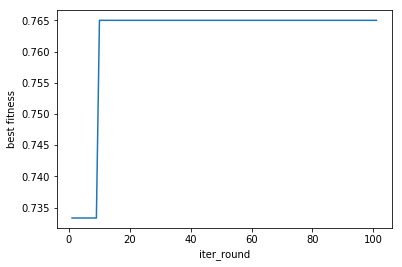

Simulated Anneal(day 2):
Solution : [0, 0, 1, 0]
Utility of solution: 0.6494444444444445




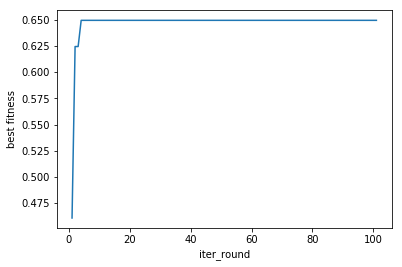

Simulated Anneal(day 3):
Solution : [0, 0, 1, 0]
Utility of solution: 0.5266666666666667




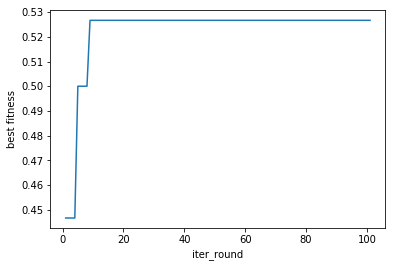

Simulated Anneal(day 4):
Solution : [1, 1, 0, 1]
Utility of solution: 0.88




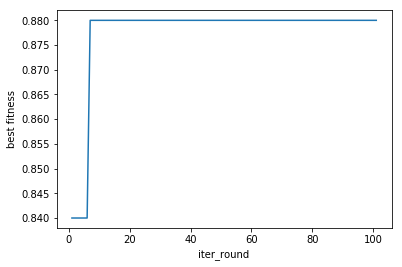

In [3]:
# 进行测试
home_initialize = HomeDataInitializer(
        device_info=r'/home/wells/Wells/OfficialWork/SIOA/WorkflowOptimize/SourceData/DeviceInfo.csv',
        external_info=r'/home/wells/Wells/OfficialWork/SIOA/WorkflowOptimize/SourceData/ExternalInfo.csv')
for day_index in range(home_initialize.external_pd.shape[0]):
    external_dic = {'UserPresence': home_initialize.external_pd.loc[day_index, 'UserPresence'],
                    'EnergyCost': home_initialize.external_pd.loc[day_index, 'EnergyCost'],
                    'Threshold': home_initialize.external_pd.loc[day_index, 'Threshold']}
    anneal = SimuAnneal(home_initialize.device_pd, external_dic,
                        max_temperature=100, min_temperature=25,
                        cooling_alpha=0.95, iter_round=100,
                        search_step=2, inner_loop_round=20,day_index=day_index+1)
    anneal.simulate_anneal_engine(pic_save_dir=r'/home/wells/Wells/OfficialWork/SIOA/WorkflowOptimize/PicSaveDir')